In [1]:
import pandas as pd

In [2]:
# df = pd.read_csv('../data/sales.csv')
df = pd.read_csv('sales.csv')

In [3]:
df.dropna(subset=['price'], inplace=True)

In [4]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [5]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year

In [6]:
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

# Timestamp Features

<font color='red'>Assignment:</font> Build a class to transform **purchase_date** into numerical features include **year**, **month**, **weekday**, and **day**.

In [7]:
class DT_Transformer(object):
    
    def fit(self, X, y=None):
        pass
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['year'] = pd.to_datetime(X.purchase_date).dt.year
        df['month'] = pd.to_datetime(X.purchase_date).dt.month
        df['weekday'] = pd.to_datetime(X.purchase_date).dt.weekday
        df['day'] = pd.to_datetime(X.purchase_date).dt.day
        return df
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

<font color='red'>Assignment:</font> Wrap up the above transformer and linear regression as a pipeline to predict **price** using these features.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def price2num(x):
    if isinstance(x, str):
        x = x.strip("$").replace(",", "")
    return float(x)

X_train = train_raw[["purchase_date"]]
y_train = train_raw["price"].map(price2num)

X_test = test_raw[["purchase_date"]]
y_test = test_raw["price"].map(price2num)

steps = [("dttf", DT_Transformer()), ("lr", LinearRegression())]

model = Pipeline(steps)
model = model.fit(X_train, y_train)

In [9]:
def loss(data, X, y_true, model):
    '''Calculate the MAE, MSE and R2 of data (str) between true and prediction with model'''
    y_pred = model.predict(X)
    print(data, "MAE: {0:.2e}".format(mean_absolute_error(y_true, y_pred)))
    print(data, "MSE: {0:.2e}".format(mean_squared_error(y_true, y_pred)))
    print(data, "R2 score : {0:.3f}".format(r2_score(y_true, y_pred)))

In [10]:
'''Train loss'''

loss("train", X_train, y_train, model)

train MAE: 1.34e+05
train MSE: 4.10e+10
train R2 score : 0.039


In [11]:
'''Test loss'''

loss("test", X_test, y_test, model)

test MAE: 1.90e+05
test MSE: 8.67e+10
test R2 score : -0.005


In [12]:
import matplotlib.pylab as plt
%matplotlib inline

Text(0, 0.5, 'y_test_pred')

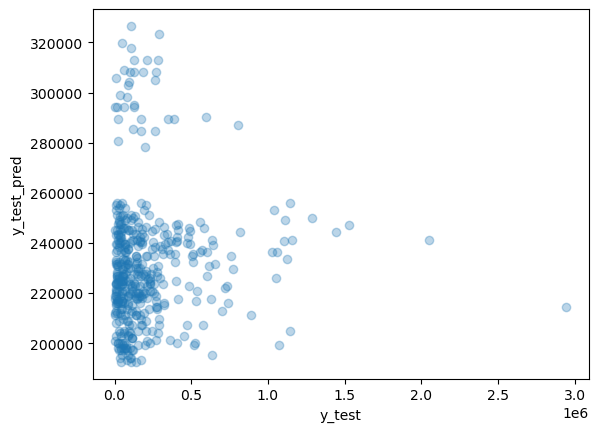

In [13]:
plt.scatter(y_test, model.predict(X_test), alpha = 0.3)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

# ARIMA

<font color='red'>Assignment:</font> Creat a new DataFrame named **new_df** containing numerical **price** and **year** of the purchase. 

In [14]:
new_data = {
    "price": df["price"].map(price2num),
    "year": pd.to_datetime(df["purchase_date"]).dt.year.astype(int)
}
new_df = pd.DataFrame(new_data)
new_df

,price,year
0,300492.0,2008
1,430570.0,1997
2,213070.0,2001
3,229174.0,2016
4,122659.0,2000
...,...,...
3192,93349.0,2016
3193,40384.0,2007
3194,1074844.0,2016
3195,55931.0,2002


<font color='red'>Assignment:</font> Get the averaged price for each year. Hint: use **groupby**. 

In [15]:
new_df.groupby("year").mean()

,price
year,
1996,92974.589744
1997,119849.041667
1998,143776.348993
1999,142815.307143
2000,151443.718310
2001,161605.382979
2002,180232.475177
2003,173716.346667
2004,192375.952703


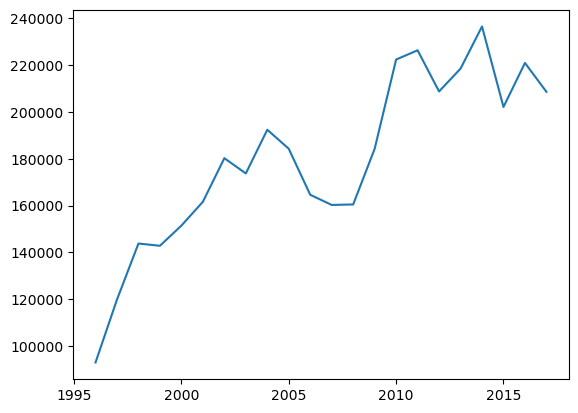

In [16]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(new_df.groupby("year").mean())

<font color='red'>Assignment:</font> Build a LinearRegression model to predict the yearly averaged price using averaged prices in the past three years. For example, to predict the averaged price in 2015 with the averaged price in 2014, 2013, and 2012. (Hint: use **shift** and you can discard the rows containing nan values.) Get the training and testing scores.

In [17]:
'''linear regression model to predict the yearly average price'''
from sklearn.model_selection import train_test_split

temp = new_df.groupby("year").mean()
lr_data = {
    "price year-3": temp.shift(3)["price"],
    "price year-2": temp.shift(2)["price"],
    "price year-1": temp.shift(1)["price"],
    "price": temp["price"]
}
lr_df = pd.DataFrame(lr_data).dropna()

df_train = lr_df[lr_df.index < 2013]
df_test = lr_df[lr_df.index >= 2013]

X_train, y_train = df_train.iloc[:, :3], df_train["price"]
X_test, y_test = df_test.iloc[:, :3], df_test["price"]

In [18]:
lr_df.head()

,price year-3,price year-2,price year-1,price
year,,,,
1999,92974.589744,119849.041667,143776.348993,142815.307143
2000,119849.041667,143776.348993,142815.307143,151443.718310
2001,143776.348993,142815.307143,151443.718310,161605.382979
2002,142815.307143,151443.718310,161605.382979,180232.475177
2003,151443.718310,161605.382979,180232.475177,173716.346667


In [19]:
df_train

,price year-3,price year-2,price year-1,price
year,,,,
1999,92974.589744,119849.041667,143776.348993,142815.307143
2000,119849.041667,143776.348993,142815.307143,151443.718310
2001,143776.348993,142815.307143,151443.718310,161605.382979
2002,142815.307143,151443.718310,161605.382979,180232.475177
2003,151443.718310,161605.382979,180232.475177,173716.346667
2004,161605.382979,180232.475177,173716.346667,192375.952703
2005,180232.475177,173716.346667,192375.952703,184252.047297
2006,173716.346667,192375.952703,184252.047297,164600.365854
2007,192375.952703,184252.047297,164600.365854,160255.994253


In [20]:
df_test

,price year-3,price year-2,price year-1,price
year,,,,
2013,222372.947020,226314.683824,208741.081081,218481.289655
2014,226314.683824,208741.081081,218481.289655,236485.390411
2015,208741.081081,218481.289655,236485.390411,202109.211921
2016,218481.289655,236485.390411,202109.211921,220901.759259
2017,236485.390411,202109.211921,220901.759259,208584.629310


In [21]:
X_train

,price year-3,price year-2,price year-1
year,,,
1999,92974.589744,119849.041667,143776.348993
2000,119849.041667,143776.348993,142815.307143
2001,143776.348993,142815.307143,151443.718310
2002,142815.307143,151443.718310,161605.382979
2003,151443.718310,161605.382979,180232.475177
2004,161605.382979,180232.475177,173716.346667
2005,180232.475177,173716.346667,192375.952703
2006,173716.346667,192375.952703,184252.047297
2007,192375.952703,184252.047297,164600.365854


In [22]:
# train the model

lr_model = LinearRegression()
lr_model = lr_model.fit(X_train, y_train)

In [23]:
'''Train loss'''
loss("train", X_train, y_train, lr_model)

train MAE: 1.13e+04
train MSE: 1.84e+08
train R2 score : 0.698


In [24]:
'''Test loss'''
loss("test", X_test, y_test, lr_model)

test MAE: 2.50e+04
test MSE: 6.85e+08
test R2 score : -3.968


In [25]:
# train the model
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler

steps = [('rescale', MinMaxScaler()),
         ('Ridge', Ridge(alpha = 1))]
l2_model = Pipeline(steps)
l2_model = l2_model.fit(X_train, y_train)

In [26]:
'''Train loss'''
loss("train", X_train, y_train, l2_model)

train MAE: 1.44e+04
train MSE: 2.98e+08
train R2 score : 0.511


In [27]:
'''Test loss'''
loss("test", X_test, y_test, l2_model)

test MAE: 1.71e+04
test MSE: 3.99e+08
test R2 score : -1.892


##### not asking you to use average as prediction, but build a linear regression model please!

<font color='red'>Assignment:</font> Plot the prediction and ground truth of yearly averaged **price** against time. 

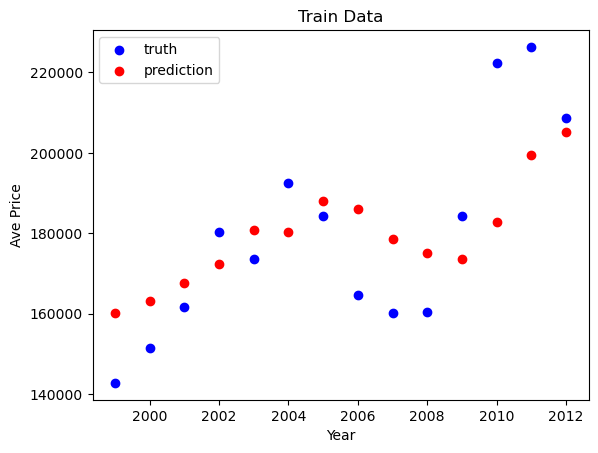

In [28]:
'''Train'''

plt.scatter(X_train.index, y_train, color="b", label="truth")
plt.scatter(X_train.index, l2_model.predict(X_train), color="r", label="prediction")
plt.xlabel("Year")
plt.ylabel("Ave Price")
plt.title("Train Data")
plt.legend()

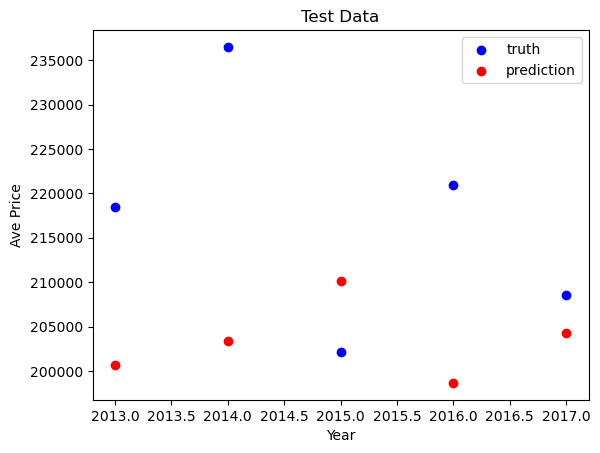

In [29]:
'''Test'''

plt.scatter(X_test.index, y_test, color="b", label="truth")
plt.scatter(X_test.index, l2_model.predict(X_test), color="r", label="prediction")
plt.xlabel("Year")
plt.ylabel("Ave Price")
plt.title("Test Data")
plt.legend()

<font color='red'>Question:</font> What is ARIMA?

**ANS:**
<br>ARIMA stands for Autoregressive Integrated Moving Average. It is a statiscal analysis model that uses time series data to either better understand the data set ot to predict future trends.

##### An example of using ARIMA

In [ ]:
temp = new_df.groupby("year").mean()

df_train = temp[temp.index < 2013]
df_test = temp[temp.index >= 2013]

##### 1. Dicky-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(new_df.groupby("year").mean())
print('ADF Statistic: %f' % result[0]) # the more negative the better
print('p-value: %f' % result[1]) # cut-off at 5%
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# our time series data is not stationary !!! differencing needed d > 0

ADF Statistic: -2.539526
p-value: 0.106151
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646


##### 2. find p, q

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\logos\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


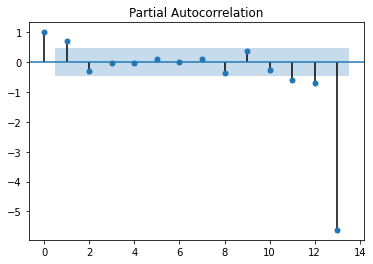

In [ ]:
# pacf plot to determine p for AR

plot_pacf(df_train)
plt.show()

# sharp cut after one lag, p = 1

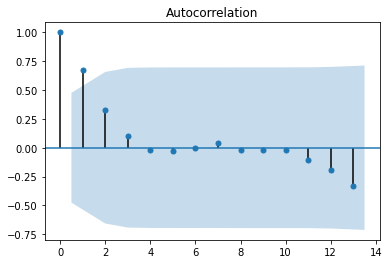

In [ ]:
# acf plot to determine q for MA

plot_acf(df_train)
plt.show()

# no sharp cut, q = 0

##### 3. build ARIMA model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

# fit model
model_arima = ARIMA(df_train, order=(1,1,0)) # order = (p, d, q)
model_arima = model_arima.fit(disp=-1)

C:\Users\logos\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\logos\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


C:\Users\logos\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\logos\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\logos\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


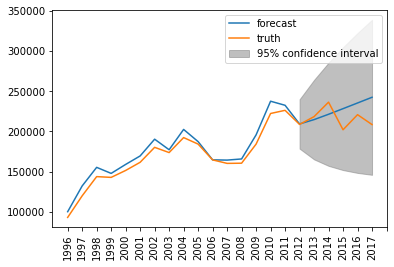

In [ ]:
# compare prediction with truth
model_arima.plot_predict(1, len(temp), plot_insample=False)
plt.plot(temp.values, label='truth')
plt.xticks(np.arange(len(temp)+1), temp.index, rotation=90)
plt.legend()
plt.show()

# Use time features and historical price to predict price (Example)

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year

In [ ]:
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

In [ ]:
class Historical_Transformer(object):
    
    def fit(self, X, y):
        self.datetime = pd.to_datetime(X)
        self.year_avg = pd.DataFrame({'year': self.datetime.dt.year, 
                                      'price': y}).groupby('year').mean()
        test = pd.DataFrame({'price': [0, 0, 0]}, index=[2015, 2016, 2017])
        self.year_avg = self.year_avg.append(test)
        self.year_avg['shift_3'] = self.year_avg.price.shift(3)
        self.year_avg['shift_4'] = self.year_avg.price.shift(4)
        self.year_avg['shift_5'] = self.year_avg.price.shift(5)
        self.year_avg.drop('price', inplace=True, axis=1)
        self.year_avg.dropna(inplace=True)
        self.year_avg['year'] = self.year_avg.index
    
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['year'] = pd.to_datetime(X).dt.year
        df['month'] = pd.to_datetime(X).dt.month
        df['weekday'] = pd.to_datetime(X).dt.weekday
        df['day'] = pd.to_datetime(X).dt.day
        df = df.merge(self.year_avg, how='left', on='year')
        if y is None:
            return np.array(df)
        else:
            df['price'] = y
            df.dropna(inplace=True)
            features = list(df.columns)
            target = 'price'
            features.remove(target)
            return np.array(df[features]), np.array(df[target])
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        X = self.transform(X, y)
        return X  

In [ ]:
htf = Historical_Transformer()

In [ ]:
X_train = train_raw.purchase_date
y_train = train_raw.price.map(lambda x: float(x.strip('$').replace(',','')))

In [ ]:
X_train, y_train = htf.fit_transform(X_train, y_train)

In [ ]:
model = Pipeline(steps=[('rescale', MinMaxScaler()),
                        ('lr', LinearRegression())])
model = model.fit(X_train, y_train)
print('MSE:', mean_squared_error(y_train, model.predict(X_train)))
print('R2:', r2_score(y_train, model.predict(X_train)))

MSE: 45471752703.38063
R2: 0.029897521925833725


In [ ]:
X_test = htf.transform(test_raw.purchase_date)
y_test = test_raw.price.map(lambda x: float(x.strip('$').replace(',', '')))

In [ ]:
print('MSE:', mean_squared_error(y_test, model.predict(X_test)))
print('R2', r2_score(y_test, model.predict(X_test)))

MSE: 86065523759.54526
R2 0.0016885676594956545


##### sklearn pipeline not supporting transformer changing sample size, do it out of the pipeline

# you can use TimeSeriesSplit to split the train/test and do cross_validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

In [ ]:
lr_df.head()

,price year-3,price year-2,price year-1,price
year,,,,
1999,92974.589744,119849.041667,143776.348993,142815.307143
2000,119849.041667,143776.348993,142815.307143,151443.718310
2001,143776.348993,142815.307143,151443.718310,161605.382979
2002,142815.307143,151443.718310,161605.382979,180232.475177
2003,151443.718310,161605.382979,180232.475177,173716.346667


In [ ]:
#hyper parameter tuning
for train_index, test_index in tscv.split(lr_df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = lr_df.iloc[train_index,1:4], lr_df.iloc[test_index,1:4]
    y_train, y_test = lr_df.iloc[train_index,0], lr_df.iloc[test_index,0]
    model = LinearRegression().fit(X_train, y_train)
#take average model performance metric

TRAIN: [0 1 2 3] TEST: [4 5 6]
TRAIN: [0 1 2 3 4 5 6] TEST: [7 8 9]
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10 11 12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16 17 18]
